In [1]:
# All imports/seeds
import torch
from model.mlp import MLP
from dataloader.utils import get_val_test_ids
from personal_utils import  (get_models_and_files, get_dataloaders_and_datasets,
                             get_embedding_files, send_through_model, send_through_patch_model,
                             send_through_decoder, generate_saliency_map, plot_saliency_map, alter_q_data, plot_reconstruction_difference)
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [2]:
from model.vq_vae import VectorQuantizedVAE
from model.vq_vae_patch_embedd import VQVAEPatch

_, _, _, train_data, val_data, test_data, train_labels, val_labels, test_labels = get_dataloaders_and_datasets()
vqvae_v1_files = dict(model='VQ-VAE-asimow-best.ckpt', mlp='my_trained_mlp.ckpt', q_emb='q_emb_v1.npy', q_ind='q_ind_v1.npy', type='VQ-VAE')
patch_vqvae_v1_files = dict(model='VQ-VAE-Patch-best-v1.ckpt', mlp='my_trained_mlp_on_patch_v1.ckpt', q_emb='patch_q_emb_v1.npy', q_ind='patch_q_ind_v1.npy', type='VQ-VAE-Patch')
patch_vqvae_v2_files = dict(model='VQ-VAE-Patch-best-v2.ckpt', mlp='my_trained_mlp_on_patch_v2.ckpt', q_emb='patch_q_emb_v2.npy', q_ind='patch_q_ind_v2.npy', type='VQ-VAE-Patch')
patch_vqvae_v4_files = dict(model='VQ-VAE-Patch-best-v4.ckpt', mlp='my_trained_mlp_on_patch_v4.ckpt', q_emb='patch_q_emb_v4.npy', q_ind='patch_q_ind_v4.npy', type='VQ-VAE-Patch')
patch_vqvae_v5_files = dict(model='VQ-VAE-Patch-best-v5.ckpt', mlp='my_trained_mlp_on_patch_v5.ckpt', q_emb='patch_q_emb_v5.npy', q_ind='patch_q_ind_v5.npy', type='VQ-VAE-Patch')
y_patch_vqvae_files = dict(model='Y-VQ-VAE-Patch-best.ckpt', mlp='my_trained_mlp_on_y_patch.ckpt', q_emb='y_patch_q_emb.npy', q_ind='y_patch_q_ind.npy', type='VQ-VAE-Patch')

def get_files_and_models(files: dict):
    # extract file paths from files dict
    model_path = f"./model_checkpoints/{files['type']}/{files['model']}"
    mlp_path = f"./MLPs/{files['mlp']}"
    q_emb_path = f"./created_files/{files['q_emb']}"
    q_ind_path = f"./created_files/{files['q_ind']}"

    # load model
    model_dict = torch.load(model_path, map_location=torch.device('cpu'))
    hparams = model_dict['hyper_parameters']
    if files['type']=='VQ-VAE':
        hparams.pop('logger')
        model = VectorQuantizedVAE(**hparams)
        model.load_state_dict(model_dict['state_dict'])

    elif files['type']=='VQ-VAE-Patch':
        if 'use_improved_vq' not in hparams: hparams['use_improved_vq'] = None
        model = VQVAEPatch(**hparams)
        model.load_state_dict(model_dict['state_dict'])
    model.eval()

    # load mlp
    my_mlp = MLP(input_size=model.enc_out_len, output_size=2, in_dim=model.embedding_dim, hidden_sizes=512)
    my_mlp.load_state_dict(torch.load(mlp_path))
    my_mlp.eval()

    # extract codebook and load quantized embeddings
    if files['type']=='VQ-VAE-Patch' and hparams["use_improved_vq"]:
        codebook = torch.round(model.vector_quantization.vq.codebooks[0], decimals=3)
    else:
        codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)
    q_emb = torch.round(torch.tensor(np.load(q_emb_path), dtype=torch.float32), decimals=3)
    q_ind = np.load(q_ind_path)
    return dict(model=model, mlp=my_mlp, codebook=codebook, q_emb=q_emb, q_ind=q_ind, hparams=hparams, type=files['type'])

# get dicts for every trained model combination containing model, mlp, codebook, q_emb, q_ind, hparams, type (VQ-VAE or VQ-VAE-Patch)
vqvae_v1 = get_files_and_models(vqvae_v1_files)
patch_vqvae_v1 = get_files_and_models(patch_vqvae_v1_files)
patch_vqvae_v2 = get_files_and_models(patch_vqvae_v2_files)
patch_vqvae_v4 = get_files_and_models(patch_vqvae_v4_files)
patch_vqvae_v5 = get_files_and_models(patch_vqvae_v5_files)
y_patch_vqvae = get_files_and_models(y_patch_vqvae_files)


(74732, 16)


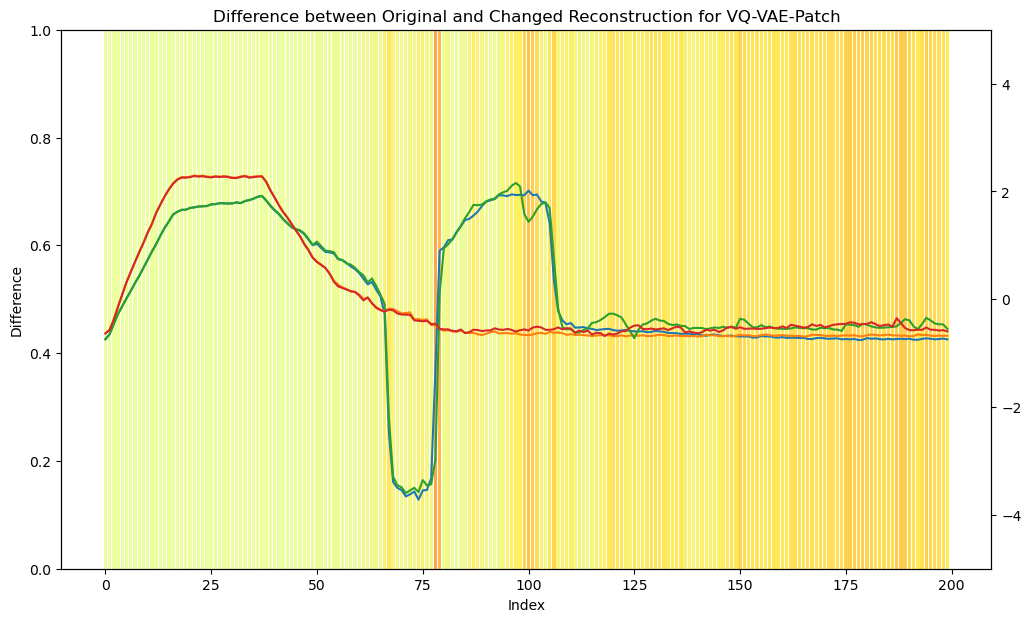

In [63]:
patch_vqvae_v1["q_ind"].shape
test_dpt = 2
original_data = torch.tensor(train_data[test_dpt])

def alter_q_data(q_data, original_data, alter_range, alter_embedding, model, model_hparams, label, plot_original=False):
    if 'use_improved_vq' not in model_hparams: model_hparams['use_improved_vq'] = None
    if model_hparams["use_improved_vq"]:
        codebook = torch.round(model.vector_quantization.vq.codebooks[0], decimals=3)
    else:
        codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)
    changed_q_data = q_data.clone().detach()
    # codebook = torch.round(model.vector_quantization.embedding.weight.data, decimals=3)
    # replacing four embeddings with least common Codebook Entry number 165
    for i in alter_range:
        changed_q_data[i] = codebook[alter_embedding] 
    reconstructed_original, _= send_through_decoder(model=model, q_data=q_data.unsqueeze(0), original_data = original_data, label=label)
    reconstructed_changed, _= send_through_decoder(model=model, q_data=changed_q_data.unsqueeze(0), original_data = original_data, label=label)
    difference = plot_reconstruction_difference(reconstructed_original=reconstructed_original[0], reconstructed_changed=reconstructed_changed[0], original=original_data, label=label, plot_original=plot_original)

current_model = get_files_and_models(patch_vqvae_v1_files)
alter_q_data(q_data=current_model["q_emb"][test_dpt], original_data=original_data, alter_range = range(12,16), alter_embedding = 2,
             model=current_model["model"], model_hparams=current_model["hparams"], label="VQ-VAE-Patch")

current_model["q_ind"].shape
reconstructed_original, _= send_through_decoder(model=patch_vqvae_v1["model"], q_data=patch_vqvae_v1["q_emb"][test_dpt].unsqueeze(0), original_data = original_data, label="VQ-VAE-Patch")
# q_indices.unsqueeze(0).shape
# plt.plot(reconstructed_original[0].detach().numpy())

(74732, 26)


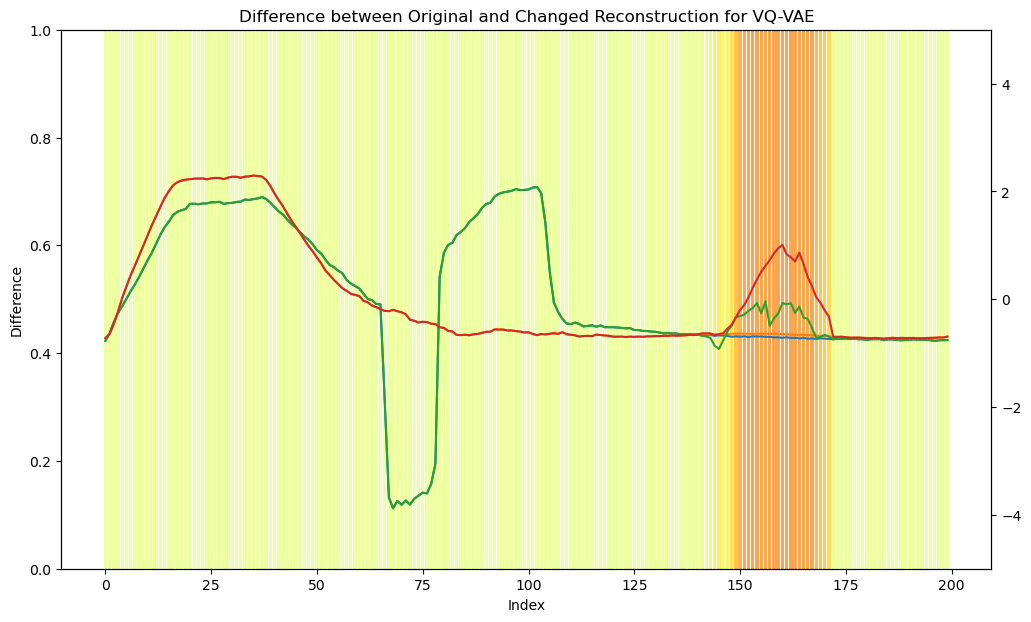

Q-Embeddings Indices:  [228 154 207 207 207 207 124  22 144 229  85 231 225 116 116 214 133 133
  57  57  57  57 168 168 168  98]


In [44]:
test_dpt = 2
original_data = torch.tensor(train_data[test_dpt])

current_model = get_files_and_models(vqvae_v1_files)
alter_q_data(q_data=current_model["q_emb"][test_dpt], original_data=original_data, alter_range = range(20, 21), alter_embedding = 207,
             model=current_model["model"], model_hparams=current_model["hparams"], label="VQ-VAE")
print("Q-Embeddings Indices: ", current_model["q_ind"][test_dpt])
            
# current_model = get_files_and_models(patch_vqvae_v1_files)
# alter_q_data(q_data=current_model["q_emb"][test_dpt], original_data=original_data, alter_range = range(0, 4), alter_embedding = 60,
#              model=current_model["model"], model_hparams=current_model["hparams"], label="VQ-VAE-Patch", plot_original=True)
# print("Q-Embeddings Indices: ", current_model["q_ind"][test_dpt])
    
# current_model = get_files_and_models(patch_vqvae_v2_files)
# alter_q_data(q_data=current_model["q_emb"][test_dpt], original_data=original_data, alter_range = range(15, 16), alter_embedding = 1,
#              model=current_model["model"], model_hparams=current_model["hparams"], label="VQ-VAE-Patch", plot_original=True)
# print("Q-Embeddings Indices: ", current_model["q_ind"][test_dpt])
    
# current_model = get_files_and_models(patch_vqvae_v4_files)
# alter_q_data(q_data=current_model["q_emb"][test_dpt], original_data=original_data, alter_range = range(15, 16), alter_embedding = 1,
#              model=current_model["model"], model_hparams=current_model["hparams"], label="VQ-VAE-Patch", plot_original=True)
# print("Q-Embeddings Indices: ", current_model["q_ind"][test_dpt])

# current_model = get_files_and_models(patch_vqvae_v5_files)
# alter_q_data(q_data=current_model["q_emb"][test_dpt], original_data=original_data, alter_range = range(15, 16), alter_embedding = 1,
#              model=current_model["model"], model_hparams=current_model["hparams"], label="VQ-VAE-Patch", plot_original=False)
# print("Q-Embeddings Indices: ", current_model["q_ind"][test_dpt])

(74732, 26)
torch.Size([26, 1])
torch.Size([26, 1])


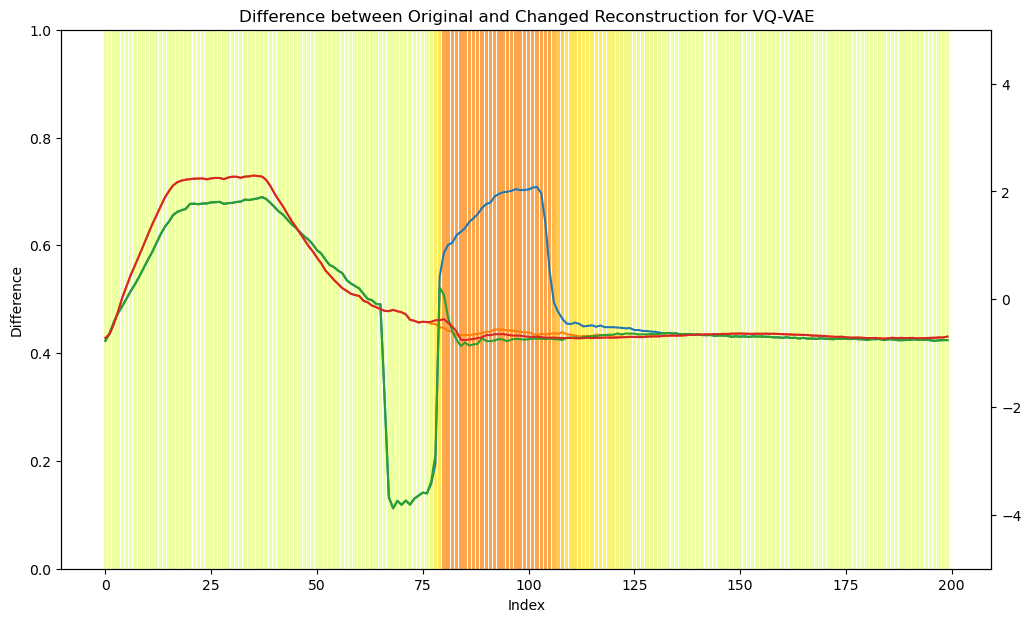

Q Indices before:  [228 154 207 207 207 207 124  22 144 229  85 231 225 116 116 214 133 133
  57  57  57  57 168 168 168  98]
Q Indices after:  [228 154 207 207 207 207 124  22 144 229  85 231  57 168 168 168 133 133
  57  57  57  57 168 168 168  98]
[ True  True  True  True  True  True  True  True  True  True  True  True
 False False False False  True  True  True  True  True  True  True  True
  True  True]
(74732, 16)
torch.Size([16, 1])
torch.Size([16, 1])


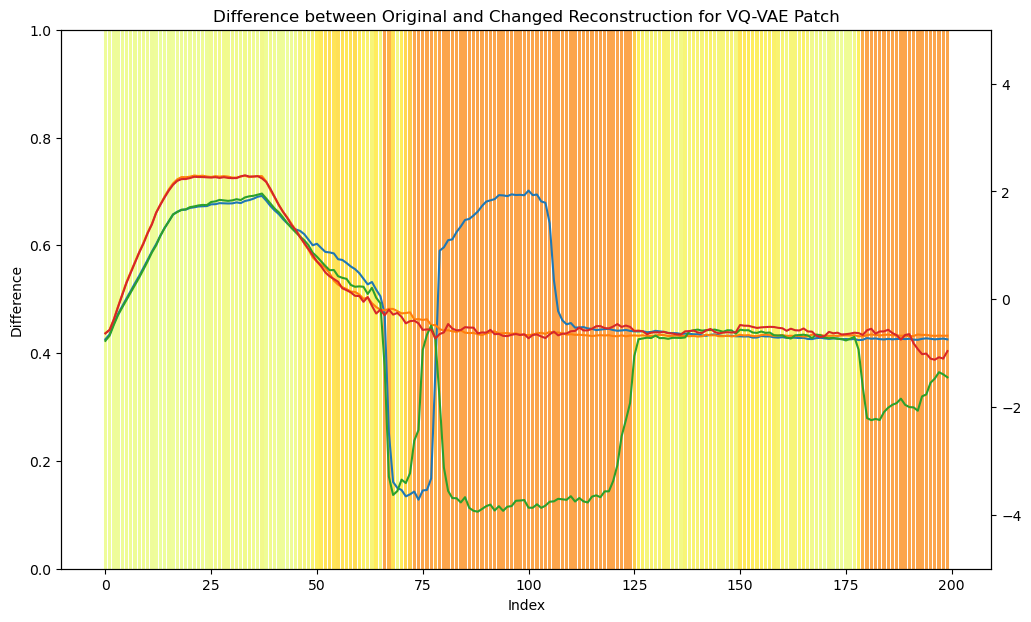

Q Indices before:  [122 167 132 229 136 243  60 250  31 188 119 166  17  60  60  60]
Q Indices after:  [122 167 132  92  91 243  60 250  31 188 119  92  91  60  60  60]
[ True  True  True False False  True  True  True  True  True  True False
 False  True  True  True]


In [81]:
def alter_input_data(original_data, alter_slice, alter_value, model, label, plot_altered=False):
    altered_input = original_data.clone()
    altered_input[alter_slice]=alter_value
    if label == "VQ-VAE":
        _, _, _, q_data, q_indices, _, _ = send_through_model(model, original_data.unsqueeze(0), reconstruct=False)
        _, _, _, changed_q_data, changed_q_indices, _, _ = send_through_model(model, altered_input.unsqueeze(0), reconstruct=False)
    else:
        _, _, _, q_data, q_indices, _, _ = send_through_patch_model(model, original_data.unsqueeze(0), reconstruct=False)
        _, _, _, changed_q_data, changed_q_indices, _, _ = send_through_patch_model(model, altered_input.unsqueeze(0), reconstruct=False)

    # correcr dimensions, so that its always [enc_out_len, 1], because Residual VQ returns Indices in 3 dimensions (num_quantizers, enc_out_len, 1)
    q_indices = q_indices.reshape(-1).unsqueeze(1)
    changed_q_indices = changed_q_indices.reshape(-1).unsqueeze(1)

    reconstructed_original, _= send_through_decoder(model=model, q_data=q_data, original_data = original_data, label=label)
    reconstructed_changed, _= send_through_decoder(model=model, q_data=changed_q_data, original_data = original_data, label=label)
    difference = plot_reconstruction_difference(reconstructed_original=reconstructed_original[0], reconstructed_changed=reconstructed_changed[0], original=altered_input, label=label, plot_original=plot_altered)
    print("Q Indices before: ", np.array(q_indices).reshape(q_indices.shape[0],))
    print("Q Indices after: ", np.array(changed_q_indices).reshape(q_indices.shape[0],))
    similarity = np.array(q_indices==changed_q_indices).reshape(q_indices.shape[0],)
    print(similarity)

test_dpt = 2
original_data = torch.from_numpy(train_data[test_dpt]).float()
# print(original_data[-20:])

current_model = get_files_and_models(vqvae_v1_files)
alter_input_data(original_data=original_data, alter_slice=slice(80,120), alter_value=-0.7, model=current_model["model"], label="VQ-VAE", plot_altered=False)

current_model = get_files_and_models(patch_vqvae_v1_files)
alter_input_data(original_data=original_data, alter_slice=slice(80,120), alter_value=-4, model=current_model["model"], label="VQ-VAE Patch", plot_altered=False)


# alter_input_data(original_data=original_data, alter_slice=slice(80,120), alter_value=-0.7, model=model, label="VQ-VAE", plot_altered=False)
# alter_input_data(original_data=original_data, alter_slice=slice(80,120), alter_value=-0.7, model=model_patch, label="VQ-VAE Patch", plot_altered=False)
# alter_input_data(original_data=original_data, alter_slice=slice(80,120), alter_value=-0.7, model=model_yannik_patch, label="VQ-VAE Yannik Patch", plot_altered=False)